Link to R sources: https://github.com/MatrixNorm/kaggle/tree/master/R_sources/house_prices

In [3]:
setwd(paste0(Sys.getenv('R_SOURCES'), '/house_prices'))

house_prices <- source('main.R', local = TRUE)$value

outliers <- house_prices$outliers

combinedDataset <- house_prices$helpers$load_data()
trainingDataset <- combinedDataset %>% filter(dataSource == 'train')

c(
    combinedDataset %>% dim %>% show_list.html("combined"),
    trainingDataset %>% dim %>% show_list.html("training")
) %>% paste0(collapse='') %>% display_html

combined 2919 82 training 1460 82

In [6]:
test_that("check some trivial invariants", {
    
    combined_strange_cases <- outliers$get_strange_cases(combinedDataset)
    combined_cleaned <- outliers$remove_outliers(combinedDataset)
    
    training_strange_cases <- outliers$get_strange_cases(trainingDataset)
    training_cleaned <- outliers$remove_outliers(trainingDataset)

    expect_equal(
        nrow(combined_strange_cases) + nrow(combined_cleaned), 
        nrow(combinedDataset)
    )
    expect_equal(
        nrow(training_strange_cases) + nrow(training_cleaned), 
        nrow(trainingDataset)
    )
    expect_equal(combined_strange_cases, training_strange_cases)
})

In [11]:
#
# SPDANM - deviation of price from neighborhood's median price
# price_per_sq - price per living area square feet
#
trainingDataset2 <- 
    trainingDataset %>%
    mutate(
        quality = case_when(
            OverallQual %in% c(1, 2, 3) ~ 'Bad',
            OverallQual %in% c(4, 5, 6) ~ 'Fair',
            OverallQual %in% c(7, 8)    ~ 'Good',
            TRUE                        ~ 'Excellent'
        ),
        price_per_sq = SalePrice / GrLivArea,
        price_log = log(SalePrice),
        area_log = log(GrLivArea)
    ) %>%
    group_by(Neighborhood) %>%
    mutate(
        SPDANM = SalePrice - median(SalePrice)
    ) %>%
    ungroup

strangeCases <- outliers$get_strange_cases(trainingDataset2)

EdwardsExcellentQual <- 
    trainingDataset2 %>% 
    filter(Neighborhood == 'Edwards', quality == 'Excellent')

strangeCases
EdwardsExcellentQual

Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,YrSold,SaleType,SaleCondition,SalePrice,dataSource,quality,price_per_sq,price_log,area_log,SPDANM
524,60,RL,130,40094,Pave,NA,IR1,Bnk,AllPub,⋯,2007,New,Partial,184750,train,Excellent,39.51027,12.12676,8.450198,63000
1299,60,RL,313,63887,Pave,NA,IR3,Bnk,AllPub,⋯,2008,New,Partial,160000,train,Excellent,28.35874,11.98293,8.637994,38250


Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,⋯,YrSold,SaleType,SaleCondition,SalePrice,dataSource,quality,price_per_sq,price_log,area_log,SPDANM
524,60,RL,130,40094,Pave,NA,IR1,Bnk,AllPub,⋯,2007,New,Partial,184750,train,Excellent,39.51027,12.12676,8.450198,63000
725,20,RL,86,13286,Pave,NA,IR1,Lvl,AllPub,⋯,2009,WD,Normal,320000,train,Excellent,188.45701,12.67608,7.437206,198250
1299,60,RL,313,63887,Pave,NA,IR3,Bnk,AllPub,⋯,2008,New,Partial,160000,train,Excellent,28.35874,11.98293,8.637994,38250


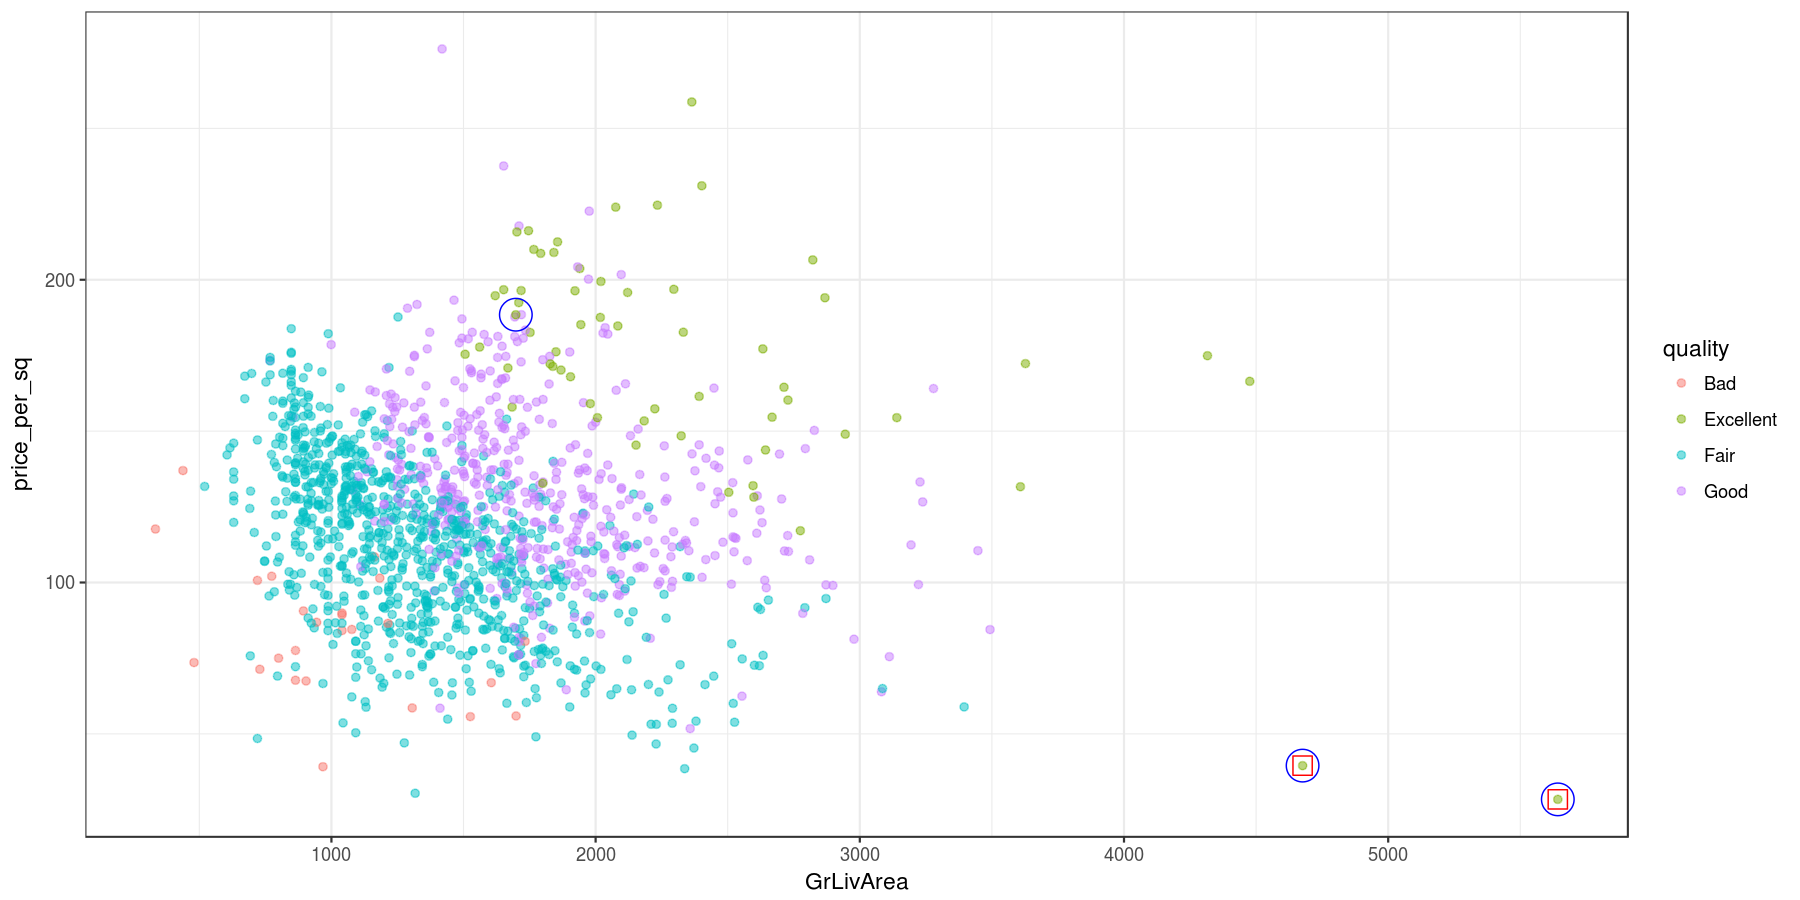

In [12]:
`@@@`(12, 6, 150)
trainingDataset2 %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=price_per_sq, color=quality), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=price_per_sq), 
           data=strangeCases, colour="red", size=4, shape=0) +
geom_point(aes(x=GrLivArea, y=price_per_sq), 
           data=EdwardsExcellentQual, colour="blue", size=7, shape=1) +
theme_bw()

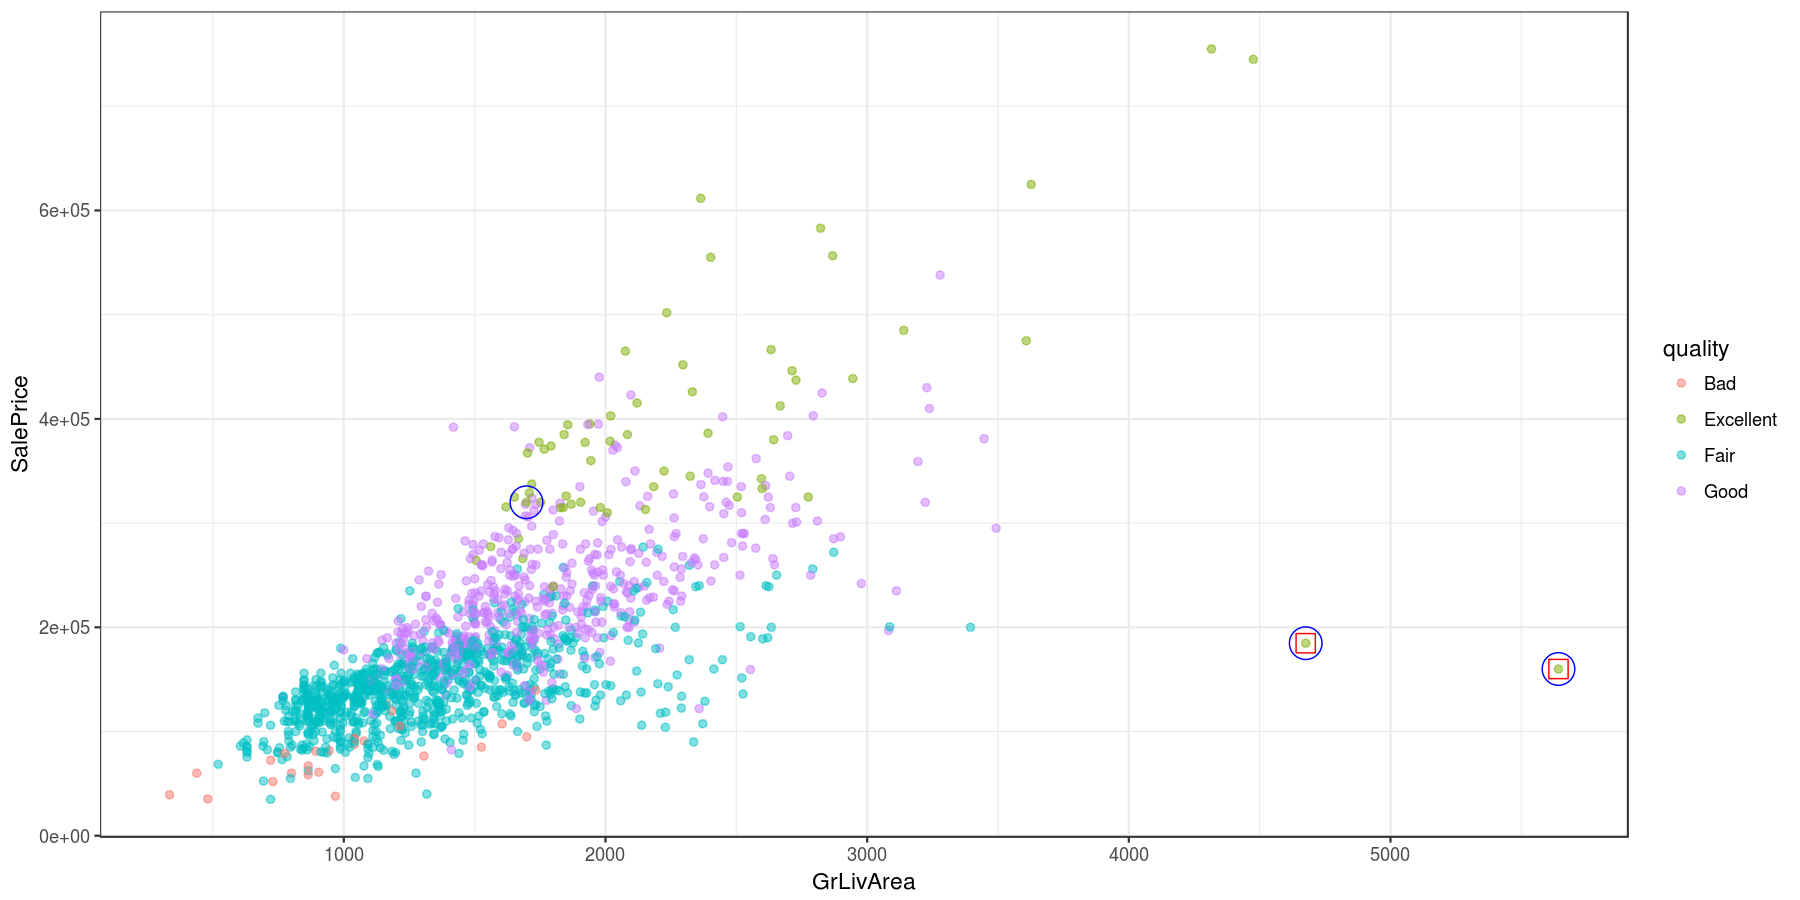

In [13]:
`@@@`(12, 6, 150)
trainingDataset2 %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=SalePrice), 
           data=strangeCases, colour="red", size=4, shape=0) +
geom_point(aes(x=GrLivArea, y=SalePrice), 
           data=EdwardsExcellentQual, colour="blue", size=7, shape=1) +
theme_bw()

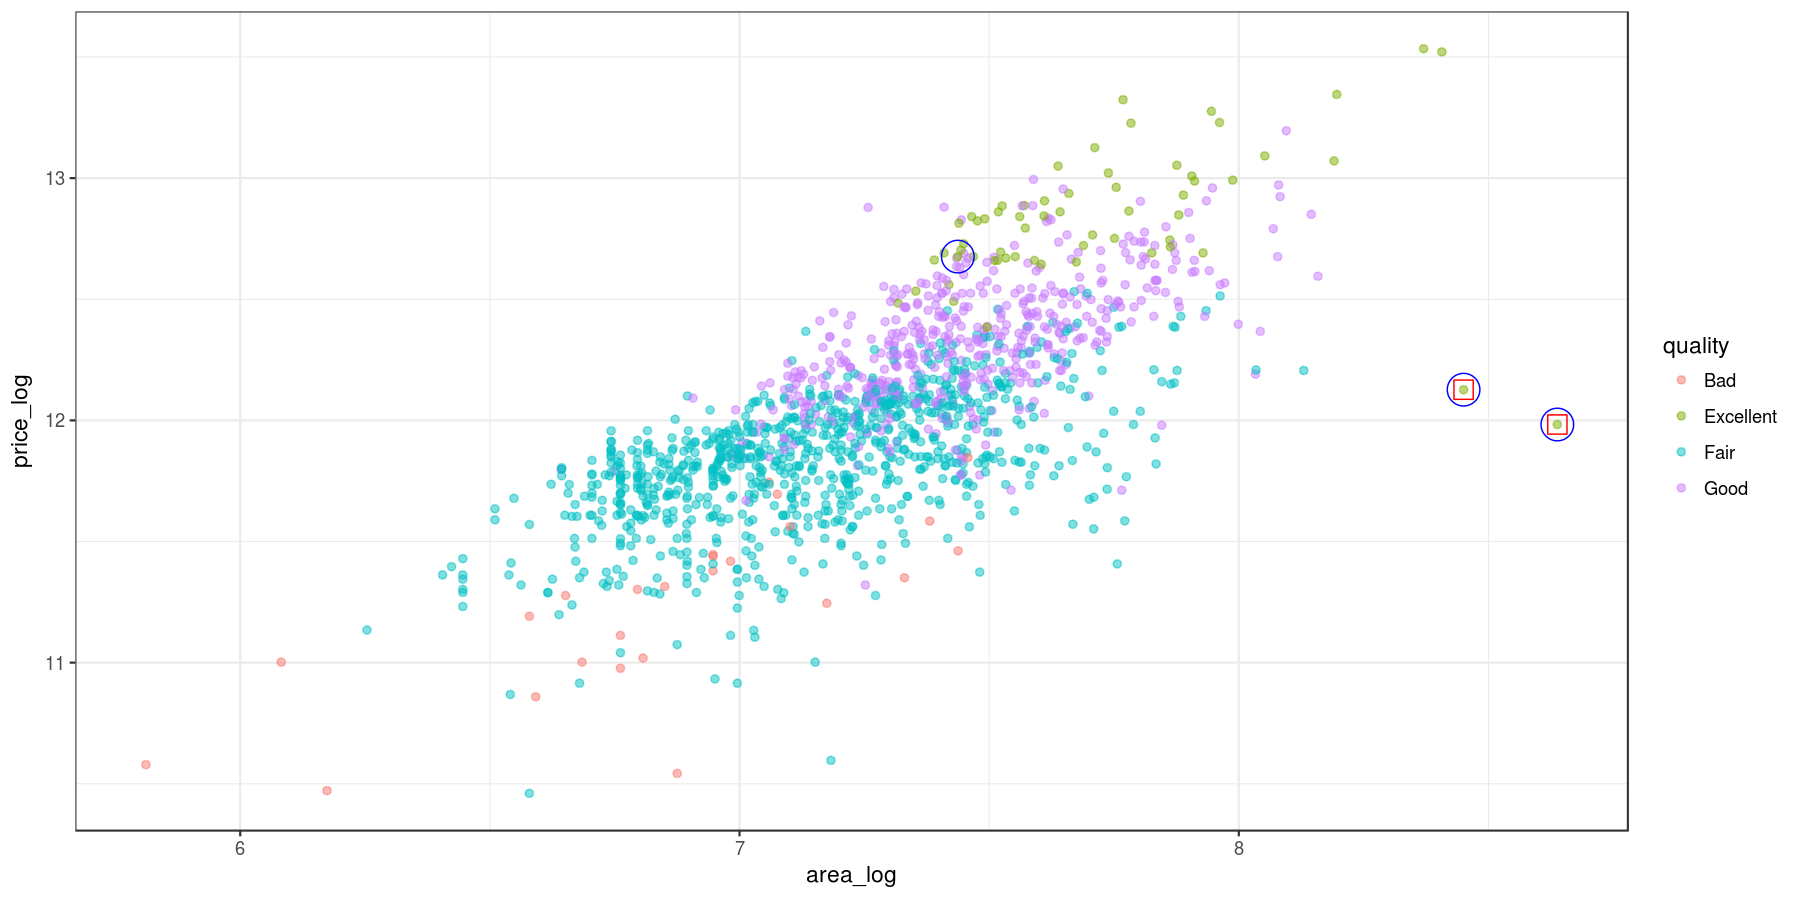

In [14]:
`@@@`(12, 6, 150)
trainingDataset2 %>%
ggplot() +
geom_point(aes(x=area_log, y=price_log, color=quality), alpha=0.5) +
geom_point(aes(x=area_log, y=price_log), 
           data=strangeCases, colour="red", size=4, shape=0) +
geom_point(aes(x=area_log, y=price_log), 
           data=EdwardsExcellentQual, colour="blue", size=7, shape=1) +
theme_bw()

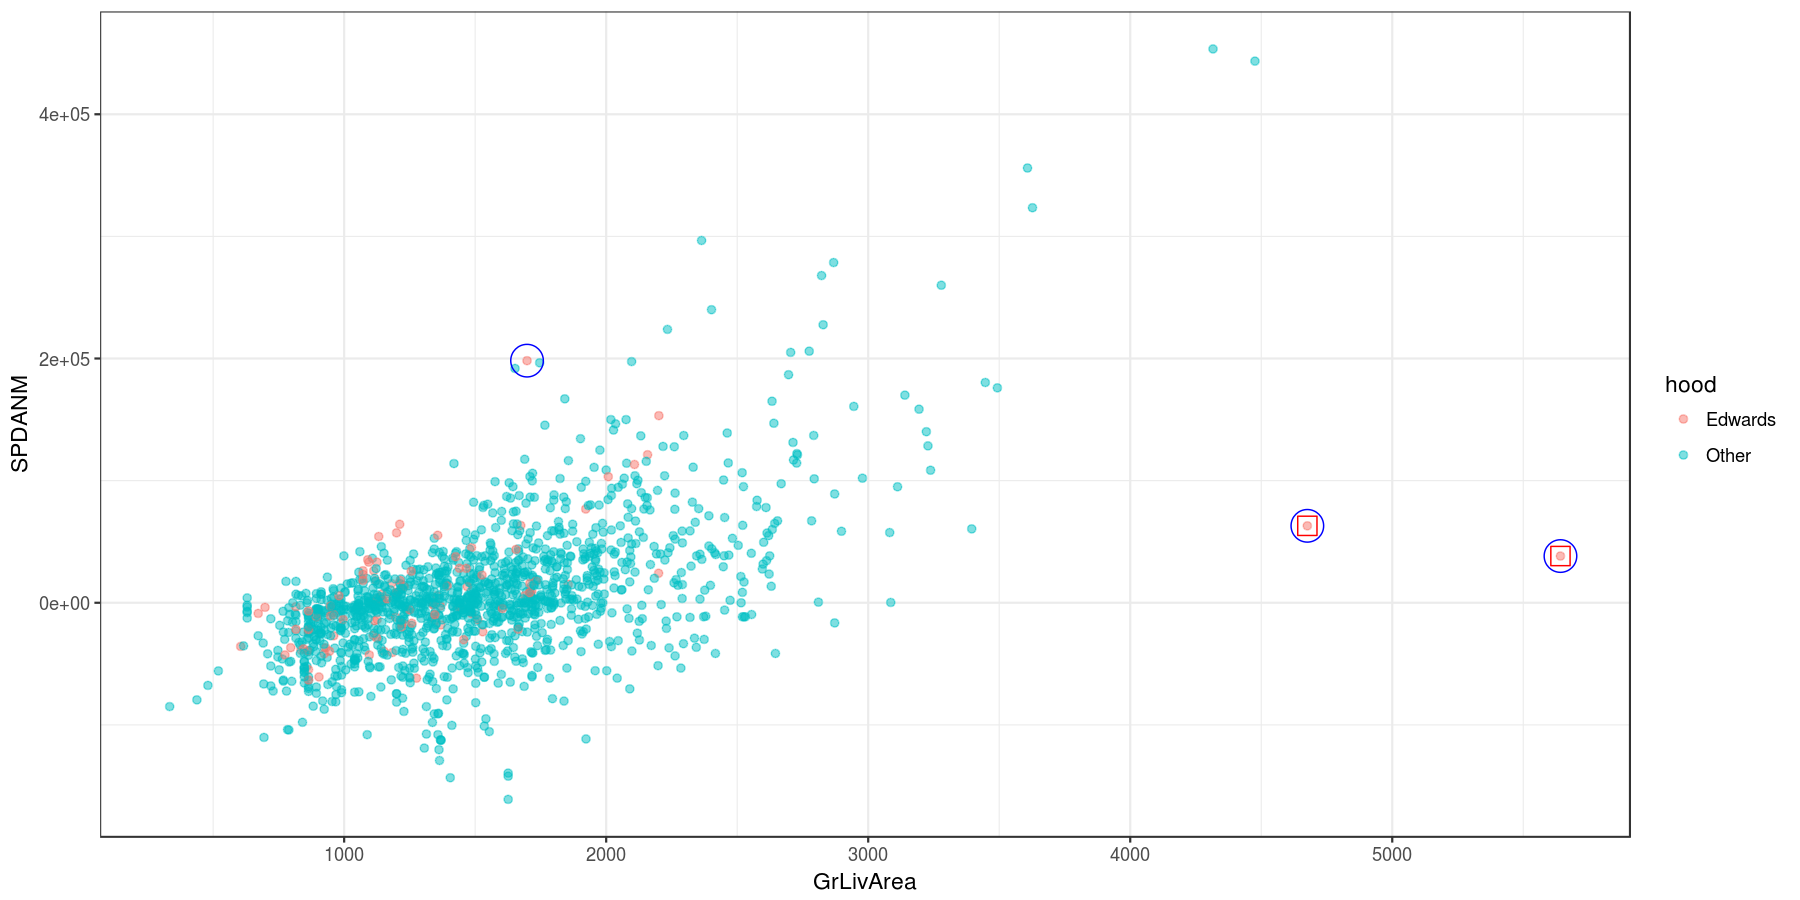

In [16]:
`@@@`(12, 6, 150)
trainingDataset2 %>%
mutate(
    hood = ifelse(Neighborhood == 'Edwards', 'Edwards', 'Other')
) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SPDANM, color=hood), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=SPDANM), 
           data=strangeCases, colour="red", size=4, shape=0) +
geom_point(aes(x=GrLivArea, y=SPDANM), 
           data=EdwardsExcellentQual, colour="blue", size=7, shape=1) +
theme_bw()

### Checking that suspicious records are thrown away.

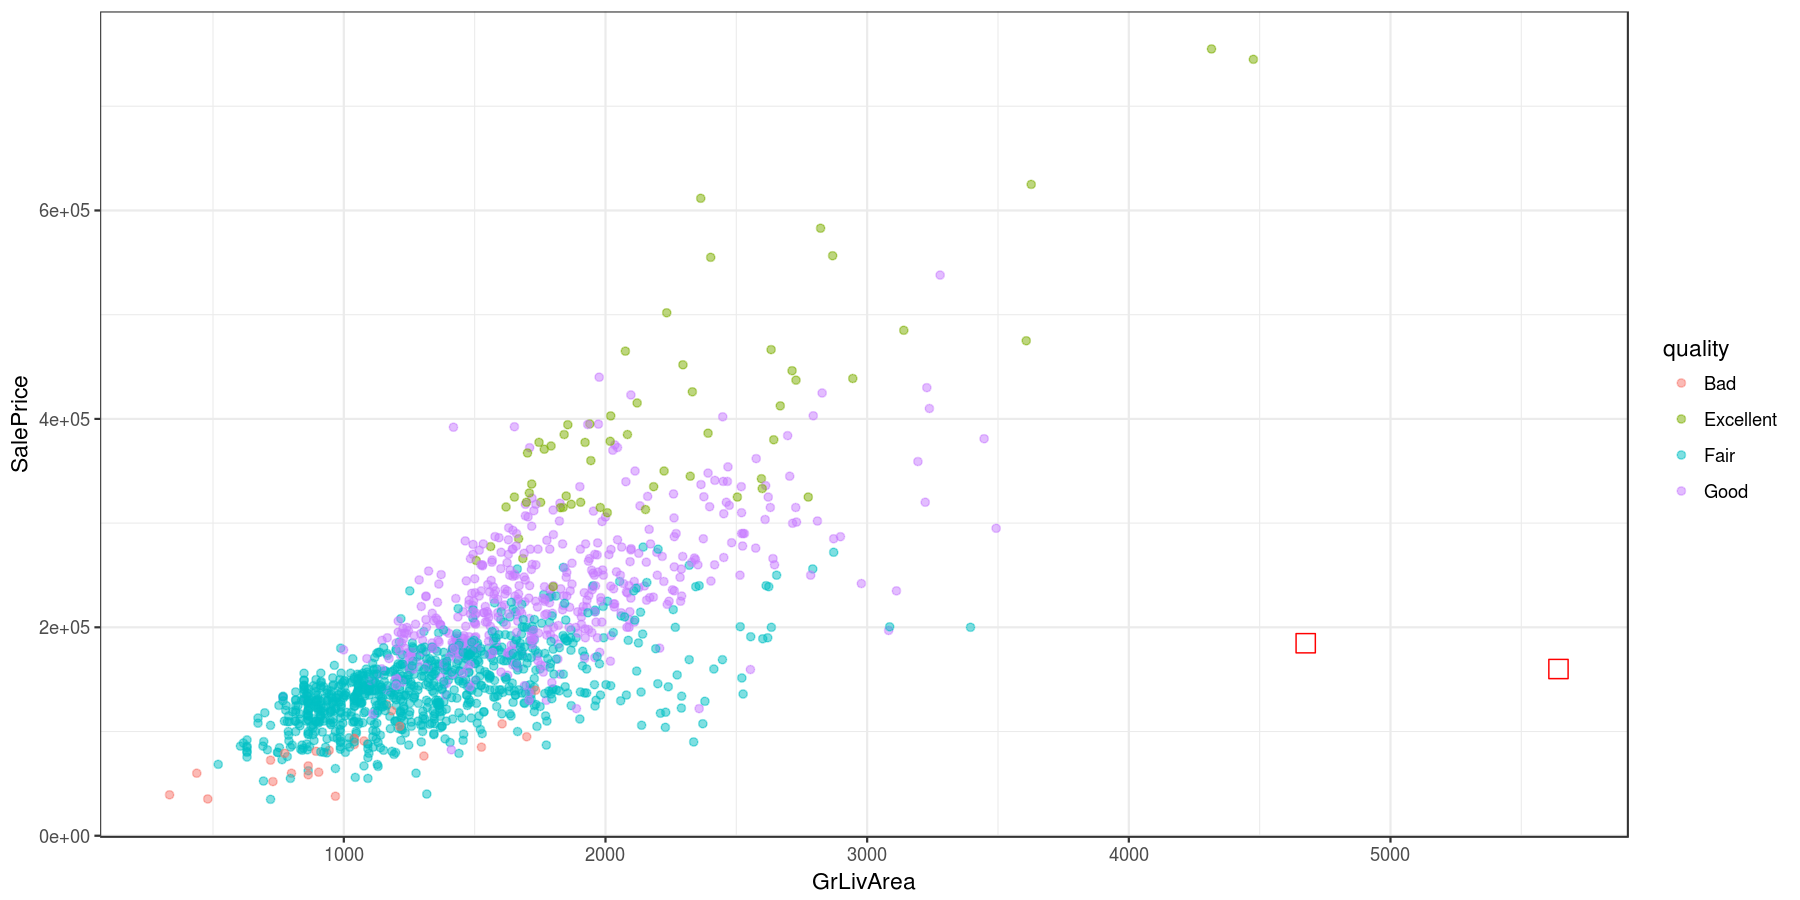

In [18]:
`@@@`(12, 6, 150)
trainingDataset2 %>%
(outliers$remove_outliers) %>%
ggplot() +
geom_point(aes(x=GrLivArea, y=SalePrice, color=quality), alpha=0.5) +
geom_point(aes(x=GrLivArea, y=SalePrice), 
           data=strangeCases, colour="red", size=4, shape=0) +
theme_bw()